In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

Данные - http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html

**1 Этап предобработки данных**
---



Чтение данных сессий lastfm из нашего набора

In [ ]:
df_user_artist_plays = pd.read_csv('lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv', sep = '\t', names = ['user','artist_id','artist','plays'])

Чтение данных профилей пользователей

In [ ]:
user_profile = pd.read_csv('lastfm-dataset-360K/usersha1-profile.tsv', sep = '\t', names = ['user','gender','age','country','signup'])

Слияние в общий набор данных

In [ ]:
full_data = pd.merge(df_user_artist_plays, user_profile, how='inner',on = 'user')

In [ ]:
full_data.count()

user         17535569
artist_id    17309433
artist       17535365
plays        17535569
gender       15948106
age          13896298
country      17535569
signup       17535569
dtype: int64

Очистим данные от исполнителя unknown


In [ ]:
unknown_artist = ['unknown','[unknown]']

In [ ]:
full_data = full_data[~full_data['artist'].isin(unknown_artist)]

In [ ]:
edit_df = full_data[['user','artist','plays']]

In [ ]:
del full_data # Очистка RAM

In [ ]:
# Удаляем нулевые значения и пропуски
edit_df.dropna(inplace=True)

In [ ]:
# Форматируем имена артистов
edit_df['artist'] = edit_df['artist'].str.lower()

In [ ]:
# Считываем данные о количестве проигрываний определенного пользователя
user_plays = pd.read_csv('lastfm-dataset-360K/user_artist.csv')

In [ ]:
# Считываем в список моих артистов
my_artists = list(set(list(user_plays['artist'])))

In [ ]:
# Считываем в список всех артистов
all_artists = list(set(list(edit_df['artist'])))

In [ ]:
# Вносим в список артистов пользователя, которых нету в общем списке  
remove_artist = []
for abc in my_artists:
    if abc not in all_artists:
        remove_artist.append(abc)

In [ ]:
# Создаем новый список, в котором исключены артисты, которых нет в датасете.
my_artist_new = [l for l in my_artists if l not in remove_artist]

In [ ]:

top_1000 = edit_df.groupby('artist', as_index=False)['plays'].sum()

In [ ]:

top_1000 = top_1000.sort_values('plays', ascending=False)

In [ ]:
top_1000 = top_1000.iloc[:1000,:].reset_index(drop = True)

In [ ]:
top_1000_artists = list(top_1000['artist'])

In [ ]:
# Отбираем только 500 лучших артистов для дальнейшего анализа
top_500_artists = top_1000_artists[:500]

In [ ]:
final_artists = list(set(top_500_artists + my_artist_new))

In [ ]:
del top_500_artists

In [ ]:
del top_1000
del top_1000_artists

In [ ]:
final_user = user_plays[user_plays['artist'].isin(final_artists)]

In [ ]:
final_user = final_user.groupby('artist',as_index=False).sum('size')

In [ ]:
# Даём имя пользователю, плейлист которого мы используем
final_user['user'] = 'User Name'

In [ ]:
final_user = final_user[['user','artist','plays']]

In [ ]:
edit_2 = edit_df[edit_df['artist'].isin(final_artists)]

In [ ]:
combined_df = pd.concat([edit_2, final_user])

In [ ]:
combined_df = combined_df.reset_index(drop = True)

In [ ]:
del final_user

In [ ]:
del edit_df

In [ ]:
combined_df

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
1,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
2,00000c289a1829a808ac09c00daf10bc3c4e223b,goldfrapp,361
3,00000c289a1829a808ac09c00daf10bc3c4e223b,dropkick murphys,302
4,00000c289a1829a808ac09c00daf10bc3c4e223b,edguy,232
...,...,...,...
6103619,User Name,the books,70
6103620,User Name,the flashbulb,118
6103621,User Name,the microphones,77
6103622,User Name,vetiver,80


In [ ]:
# Создадим сводную таблицу для анализа, матрицу пространства откликов
lastfm = combined_df.pivot_table('plays','user','artist')

In [ ]:
lastfm

artist,2pac,3 doors down,30 seconds to mars,50 cent,65daysofstatic,a day to remember,a perfect circle,a tribe called quest,abba,ac/dc,aerosmith,aesop rock,afi,against me!,air,akira yamaoka,alanis morissette,alexisonfire,alice cooper,alice in chains,alicia keys,alkaline trio,all that remains,all time low,amon amarth,amon tobin,amorphis,amy winehouse,anathema,anberlin,andrew bird,ani difranco,animal collective,annie,anti-flag,antony and the johnsons,apes & androids,aphex twin,apocalyptica,arcade fire,...,the rolling stones,the roots,the shins,the smashing pumpkins,the smiths,the streets,the strokes,the used,the velvet underground,the white stripes,the who,therion,they might be giants,thievery corporation,three days grace,thrice,timbaland,tiësto,tom waits,tool,tori amos,travis,trivium,tv on the radio,u2,ulver,underoath,unkle,vampire weekend,van halen,venetian snares,vetiver,vnv nation,weezer,why?,wilco,within temptation,yann tiersen,yeah yeah yeahs,植松伸夫
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00001411dc427966b17297bf4d69e7e193135d89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1373.0,NaN,NaN,NaN,NaN,NaN,NaN,1899.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00007a47085b9aab8af55f52ec8846ac479ac4fe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,NaN,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.0,NaN,NaN,NaN,NaN,NaN,NaN,203.0,75.0,NaN,NaN,67.0,213.0,NaN,143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,91.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe7823f67b433b45f22056467db921c1d3d7d0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fffe8637bd8234309e871409c7ebef99a720afc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fffe8c7f952d9b960a56ed4dcb40a4

In [ ]:
# Заменяем пустые значения на 0
lastfm.fillna(0, inplace=True)

In [ ]:
del combined_df

In [ ]:
# замена значений > 0 на 1, создаем  для использования её в расчете рекомендаций
lastfm_df = lastfm.apply(lambda x:[1 if y > 0 else y for y in x])

In [ ]:
lastfm_df

artist,2pac,3 doors down,30 seconds to mars,50 cent,65daysofstatic,a day to remember,a perfect circle,a tribe called quest,abba,ac/dc,aerosmith,aesop rock,afi,against me!,air,akira yamaoka,alanis morissette,alexisonfire,alice cooper,alice in chains,alicia keys,alkaline trio,all that remains,all time low,amon amarth,amon tobin,amorphis,amy winehouse,anathema,anberlin,andrew bird,ani difranco,animal collective,annie,anti-flag,antony and the johnsons,apes & androids,aphex twin,apocalyptica,arcade fire,...,the rolling stones,the roots,the shins,the smashing pumpkins,the smiths,the streets,the strokes,the used,the velvet underground,the white stripes,the who,therion,they might be giants,thievery corporation,three days grace,thrice,timbaland,tiësto,tom waits,tool,tori amos,travis,trivium,tv on the radio,u2,ulver,underoath,unkle,vampire weekend,van halen,venetian snares,vetiver,vnv nation,weezer,why?,wilco,within temptation,yann tiersen,yeah yeah yeahs,植松伸夫
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00001411dc427966b17297bf4d69e7e193135d89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00004d2ac9316e22dc007ab2243d6fcb239e707d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00007a47085b9aab8af55f52ec8846ac479ac4fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe7823f67b433b45f22056467db921c1d3d7d0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fffe8637bd8234309e871409c7ebef99a720afc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fffe8c7f952d9b960a56ed4dcb40a415d924b224,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
lastfm_df['my_artists_sum'] = lastfm_df[my_artist_new].sum(axis = 1)

In [ ]:
lastfm_subset = lastfm_df[lastfm_df['my_artists_sum'] > 4]

In [ ]:
lastfm_subset.drop(['my_artists_sum'], inplace=True, axis = 1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:

lastfm_df.drop(['my_artists_sum'], inplace = True, axis = 1)

In [ ]:
lastfm_subset.to_csv('lastfm1.csv')
lastfm_df.to_csv('lastfm.csv')

In [ ]:
del lastfm_df

**2 Настраиваем коллаборативную фильтрацию с использованием функций схожести после обработки данных**
---

In [ ]:
lastfm_subset = pd.read_csv('lastfm1.csv')

In [ ]:
data_items = lastfm_subset.drop('user', 1)

In [ ]:
# расчет функции схожести с помощью формулы Евклидова расстояния
magnitude = np.sqrt(np.square(data_items).sum(axis=1))

In [ ]:
# расчитываем значения в матрице по функции схожести
data_items = data_items.divide(magnitude, axis='index')

In [ ]:
# метод для расчета меры сходства Cosine similarity (Коэффициент Отаи)
def calculate_similarity(data_items):
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index= data_items.columns, columns= data_items.columns)
    return sim

In [ ]:
# Строим итоговую матрицу схожести
data_matrix = calculate_similarity(data_items)

In [ ]:
data_matrix

,2pac,3 doors down,30 seconds to mars,50 cent,65daysofstatic,a day to remember,a perfect circle,a tribe called quest,abba,ac/dc,aerosmith,aesop rock,afi,against me!,air,akira yamaoka,alanis morissette,alexisonfire,alice cooper,alice in chains,alicia keys,alkaline trio,all that remains,all time low,amon amarth,amon tobin,amorphis,amy winehouse,anathema,anberlin,andrew bird,ani difranco,animal collective,annie,anti-flag,antony and the johnsons,apes & androids,aphex twin,apocalyptica,arcade fire,...,the rolling stones,the roots,the shins,the smashing pumpkins,the smiths,the streets,the strokes,the used,the velvet underground,the white stripes,the who,therion,they might be giants,thievery corporation,three days grace,thrice,timbaland,tiësto,tom waits,tool,tori amos,travis,trivium,tv on the radio,u2,ulver,underoath,unkle,vampire weekend,van halen,venetian snares,vetiver,vnv nation,weezer,why?,wilco,within temptation,yann tiersen,yeah yeah yeahs,植松伸夫
2pac,1.000000,0.008991,0.023333,0.200078,0.013406,0.010395,0.031496,0.120759,0.002800,0.032217,0.022026,0.128122,0.039164,0.022291,0.051611,0.023436,0.012330,0.032462,0.011511,0.031217,0.032300,0.028138,0.041605,0.011564,0.000000,0.032937,0.000000,0.021530,0.007499,0.005849,0.019373,0.016448,0.029666,0.009981,0.003984,0.005823,0.000000,0.053767,0.010174,0.041640,...,0.036331,0.100126,0.025344,0.041856,0.024932,0.030060,0.025231,0.003835,0.022207,0.025469,0.030361,0.000000,0.009688,0.046439,0.024228,0.022135,0.049611,0.020484,0.020927,0.038925,0.014275,0.010995,0.011552,0.020327,0.035938,0.014741,0.037663,0.026173,0.014984,0.013551,0.021054,0.004582,0.003741,0.022896,0.022944,0.012429,0.015959,0.006176,0.008954,0.030754
3 doors down,0.008991,1.000000,0.071473,0.010789,0.003023,0.000000,0.053970,0.002258,0.008787,0.020299,0.093682,0.000000,0.007896,0.004302,0.051723,0.018456,0.058084,0.020447,0.012000,0.018926,0.011512,0.000000,0.000000,0.000000,0.000000,0.016523,0.015054,0.029165,0.055280,0.000000,0.002682,0.002386,0.002231,0.003262,0.000000,0.010913,0.000000,0.013978,0.006106,0.011851,...,0.016160,0.000000,0.012272,0.029034,0.006543,0.013472,0.022858,0.000000,0.001614,0.023892,0.008220,0.026383,0.006805,0.032210,0.153478,0.017744,0.018799,0.019650,0.001509,0.031425,0.029523,0.039287,0.000000,0.007357,0.058123,0.011600,0.000000,0.040600,0.004284,0.011330,0.002328,0.003352,0.008047,0.007304,0.000000,0.001788,0.032838,0.015428,0.006042,0.004958
30 seconds to mars,0.023333,0.071473,1.000000,0.009309,0.031335,0.015774,0.082963,0.006378,0.003330,0.011032,0.012280,0.016100,0.051926,0.002594,0.051662,0.050308,0.029270,0.093536,0.000000,0.009879,0.003729,0.019580,0.029070,0.015733,0.023110,0.016752,0.014019,0.032622,0.037644,0.091609,0.003414,0.003300,0.004931,0.000000,0.023096,0.009106,0.000000,0.032191,0.019170,0.023994,...,0.017039,0.004755,0.010963,0.044916,0.005272,0.011260,0.023790,0.055618,0.002288,0.026595,0.004490,0.000000,0.000000,0.031785,0.095748,0.061575,0.012201,0.016161,0.004649,0.045845,0.028383,0.029576,0.000000,0.016550,0.043857,0.000000,0.030144,0.033207,0.004143,0.000000,0.010812,0.002460,0.028179,0.005779,0.006012,0.000000,0.021594,0.010555,0.014014,0.005646
50 cent,0.200078,0.010789,0.009309,1.000000,0.010291,0.000000,0.018789,0.041236,0.008375,0.033748,0.035960,0.063959,0.009343,0.008301,0.056799,0.007360,0.006831,0.031672,0.019399,0.007740,0.031502,0.019244,0.017547,0.000000,0.000000,0.021185,0.000000,0.018516,0.002930,0.023023,0.008387,0.015393,0.010176,0.013331,0.018618,0.009739,0.000000,0.033438,0.014354,0.026406,...,0.019315,0.049026,0.015624,0.032334,0.011790,0.035893,0.025323,0.023788,0.001071,0.029967,0.006864,0.000000,0.001726,0.034469,0.000000,0.012017,0.079722,0.033883,0.012762,0.014638,0.010696,0.018288,0.000000,0.016894,0.022819,0.000000,0.017589,0.022410,0.010665,0.016549,0.016430,0.000000,0.006449,0.025656,0.008165,0.010161,0.010808,0.007218,0.014087,0.031883
65daysofstatic,0.013406,0.003023,0.031335,0.010291,1.000000,0.006038,0.083013,0.018774,0.005021,0.01

**3 Тестируем рекомендательную систему**
---

Найдем топ 10 артистов для группы Queen

In [ ]:
# Берем группу из матрицы похожести
vizdf = pd.DataFrame(data_matrix.loc['queen'].nlargest(11)[1:])
vizdf.columns = ['cosine_similarity']


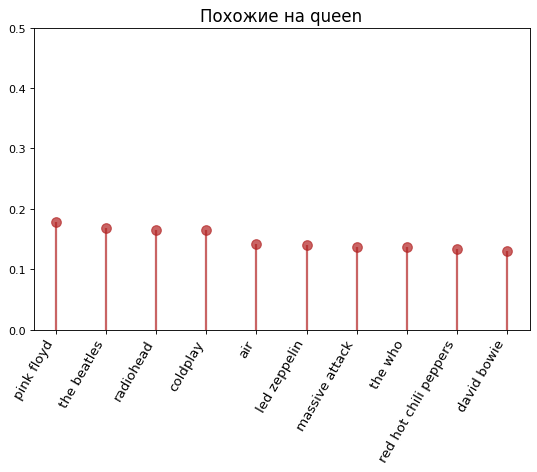

In [ ]:
# Рисуем графики
fig, ax = plt.subplots(figsize=(8,5), dpi= 80)
ax.vlines(x=vizdf.index, ymin=0, ymax=vizdf.cosine_similarity, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=vizdf.index, y=vizdf.cosine_similarity, s=75, color='firebrick', alpha=0.7)

ax.set_title('Похожие на queen', fontdict={'size':15})
ax.set_xticks(vizdf.index)
ax.set_xticklabels(vizdf.index, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, .5)

plt.show()

In [ ]:
vizdf = pd.DataFrame(data_matrix.loc['rihanna'].nlargest(11)[1:])
vizdf.columns = ['cosine_similarity']

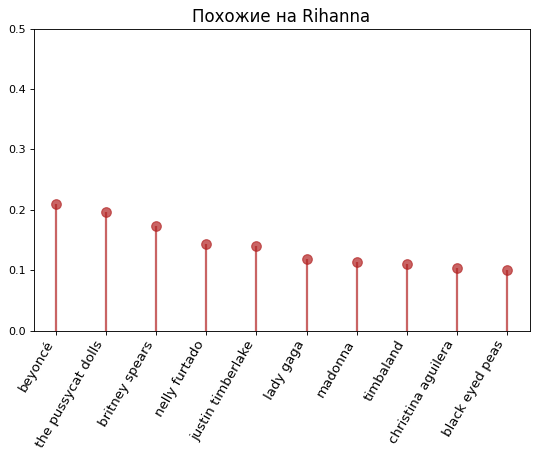

In [ ]:
fig, ax = plt.subplots(figsize=(8,5), dpi= 80)
ax.vlines(x=vizdf.index, ymin=0, ymax=vizdf.cosine_similarity, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=vizdf.index, y=vizdf.cosine_similarity, s=75, color='firebrick', alpha=0.7)

ax.set_title('Похожие на Rihanna', fontdict={'size':15})
ax.set_xticks(vizdf.index)
ax.set_xticklabels(vizdf.index, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, .5)

plt.show()

In [ ]:
vizdf = pd.DataFrame(data_matrix.loc['eminem'].nlargest(11)[1:])
vizdf.columns = ['cosine_similarity']

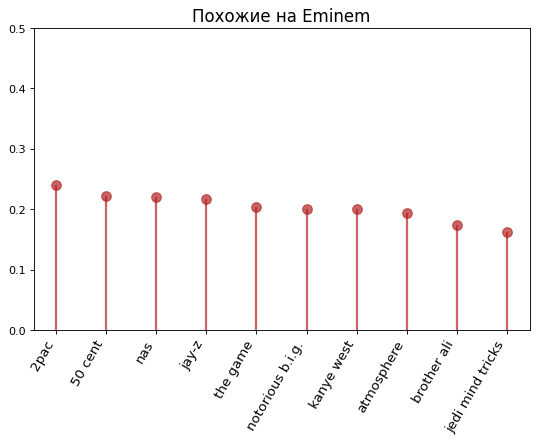

In [ ]:
fig, ax = plt.subplots(figsize=(8,5), dpi= 80)
ax.vlines(x=vizdf.index, ymin=0, ymax=vizdf.cosine_similarity, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=vizdf.index, y=vizdf.cosine_similarity, s=75, color='firebrick', alpha=0.7)

ax.set_title('Похожие на Eminem', fontdict={'size':15})
ax.set_xticks(vizdf.index)
ax.set_xticklabels(vizdf.index, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, .5)

plt.show()

Рекомендуемые исполнители для нашего пользователя


In [ ]:
# Создание нового фрейма данных с 10 ближайшими соседями (наиболее похожими) для каждого исполнителя.
data_neighbours = pd.DataFrame(index=data_matrix.columns, columns=range(1,11))
for i in range(0, len(data_matrix.columns)):
    data_neighbours.iloc[i,:10] = data_matrix.iloc[0:,i].sort_values(ascending=False)[:10].index

In [ ]:
def recommendation_for_user(user):
  user_index = lastfm_subset[lastfm_subset.user == user].index.tolist()[0]
  # Получение исполнителей, которые проигрывал пользователь.
  known_user_likes = data_items.iloc[user_index]
  known_user_likes = known_user_likes[known_user_likes >0].index.values
  most_similar_to_likes = data_neighbours.loc[known_user_likes]
  similar_list = most_similar_to_likes.values.tolist()
  similar_list = list(set([item for sublist in similar_list for item in sublist]))
  neighbourhood = data_matrix[similar_list].loc[similar_list]
  # вектор, содержащий только соседей и известные пользователю прослушивания.
  user_vector = data_items.iloc[user_index].loc[similar_list]
  # Расчет очков.
  score = neighbourhood.dot(user_vector).div(neighbourhood.sum(axis=1))
  # Отбрасываем исполнителей, которых проигрывал пользователь.
  score = score.drop(known_user_likes)
  print('Рекомендации для пользователя ' + user)
  print()
  print(score.nlargest(20))

In [ ]:
recommendation_for_user('User Name')

Рекомендации для пользователя User Name

venetian snares            0.068485
brian eno                  0.061005
burial                     0.060134
bonobo                     0.058180
the cinematic orchestra    0.058107
sonic youth                0.057302
my bloody valentine        0.056831
björk                      0.055776
mogwai                     0.055593
shpongle                   0.054576
dj shadow                  0.053848
blonde redhead             0.053623
sigur rós                  0.053207
thievery corporation       0.052957
beck                       0.052924
antony and the johnsons    0.052890
rjd2                       0.052872
m83                        0.052834
beirut                     0.052829
the magnetic fields        0.052746
dtype: float64


In [ ]:
# вектор, содержащий только соседей и известные пользователю прослушивания.
user_vector = data_items.iloc[user_index].loc[similar_list]

In [ ]:
vizdf = pd.DataFrame(score.nlargest(10))
vizdf.columns = ['similarity_score']

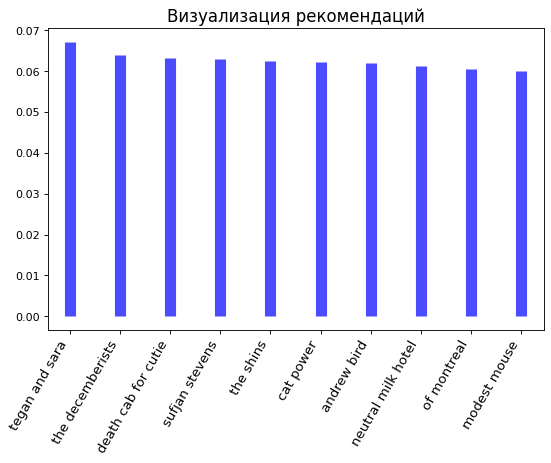

In [ ]:

fig, ax = plt.subplots(figsize=(8,5), facecolor = 'white',dpi= 80)
ax.vlines(x=vizdf.index, ymin=0, ymax=vizdf.similarity_score, color='blue', alpha=0.7, linewidth=10)
ax.set_title('Визуализация рекомендаций', fontdict={'size':15})
ax.set_xticks(vizdf.index)
ax.set_xticklabels(vizdf.index, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})

plt.show()

**4 Проверка предпочтений**
--

In [ ]:
user = 'fffe3e8eb1b2db8dcb3f3fe753552d5803d085f1'

In [ ]:
recommendation_for_user(user)

Рекомендации для пользователя fffe3e8eb1b2db8dcb3f3fe753552d5803d085f1

tegan and sara          0.067131
the decemberists        0.063895
death cab for cutie     0.063063
sufjan stevens          0.063044
the shins               0.062501
cat power               0.062164
andrew bird             0.061846
neutral milk hotel      0.061138
of montreal             0.060550
modest mouse            0.060021
devendra banhart        0.059701
the magnetic fields     0.059035
kings of convenience    0.058585
beirut                  0.058518
cocorosie               0.057785
vampire weekend         0.057608
bob dylan               0.057500
animal collective       0.057467
interpol                0.056714
patrick wolf            0.056297
dtype: float64


In [ ]:
df_user_artist_plays[df_user_artist_plays['user'] == user][['artist', 'plays']].head(20)

,artist,plays
17535283,bright eyes,2984
17535284,belle and sebastian,1041
17535285,metric,798
17535286,brand new,780
17535287,rilo kiley,762
17535288,regina spektor,639
17535289,feist,540
17535290,camera obscura,417
17535291,bat for lashes,301
17535292,claude debussy,267


Для данного пользователя предлагаются группы, которые он ещё не прослушивал и данные группы соответствуют по жанрам (рок, инди, инди-рок), прослушанным исполнителям

In [ ]:
user = '00007a47085b9aab8af55f52ec8846ac479ac4fe'

In [ ]:
recommendation_for_user(user)

Рекомендации для пользователя 00007a47085b9aab8af55f52ec8846ac479ac4fe

venetian snares            0.072313
brian eno                  0.064794
burial                     0.063639
my bloody valentine        0.061102
sonic youth                0.060563
bonobo                     0.060135
the cinematic orchestra    0.059966
mogwai                     0.059878
björk                      0.057990
shpongle                   0.057866
jedi mind tricks           0.057589
dj shadow                  0.056729
blonde redhead             0.056609
sigur rós                  0.056325
rjd2                       0.055903
dtype: float64


In [ ]:
df_user_artist_plays[df_user_artist_plays['user'] == user][['artist', 'plays']].head(20)

,artist,plays
195,devendra banhart,456
196,boards of canada,407
197,cocorosie,386
198,aphex twin,213
199,animal collective,203
200,atmosphere,189
201,joanna newsom,184
202,air,178
203,portishead,162
204,massive attack,149


Для данного пользователя также предлагаются группы и исполнители, которые он ещё не прослушивал и данные группы соответствуют по жанрам, манере исполнения, прослушанным исполнителям. Стоит отметить, что рекомендуются отдельные композиторы/авторы-исполнители (brian eno, venetian snares, burial) и дуэты (shpongle), а данный пользователь как раз любитель индвидуальных авторов-исполнителей (devendra banhart) и дуэтов (cocorosie, boards of canada, air)

In [ ]:
user = 'fffe8637bd8234309e871409c7ebef99a720afc1'
recommendation_for_user(user)

Рекомендации для пользователя fffe8637bd8234309e871409c7ebef99a720afc1

stars                   0.066993
tegan and sara          0.064205
the decemberists        0.063859
andrew bird             0.063044
bright eyes             0.062928
elliott smith           0.062922
the mountain goats      0.061492
devendra banhart        0.061168
the shins               0.060974
cocorosie               0.059976
modest mouse            0.059935
kings of convenience    0.059567
animal collective       0.059546
beirut                  0.059509
belle and sebastian     0.059213
dtype: float64


In [ ]:
df_user_artist_plays[df_user_artist_plays['user'] == user][['artist', 'plays']].head(20)

,artist,plays
17535426,my bloody valentine,2912
17535427,sonic youth,1099
17535428,tina dico,749
17535429,sufjan stevens,520
17535430,joanna newsom,497
17535431,drive-by truckers,470
17535432,lush,470
17535433,sia,449
17535434,fleetwood mac,422
17535435,metric,329


Данному пользователю, тоже рекомендуются исполнители, которых он не прослушивал, похожие по жанровым предпочтениям.